# STA9131 Assignment 5-2: Transformers

Before we start, please put your name, ID number, option (and your group members', if any) in following format: e.g., <br>
```
name = 'Kibok Lee'
idnum = '2022123456'
option = 1
group = {
    '2022123457': 'Alice Ahn',
    '2022123458': 'Bob Bae',
    '2022123459': 'Carol Choi',
}
```

In [1]:
# TODO: Put your name, id number, option (and your group members', if any):
# option 1: You did your assignment yourself.
# option 2: You didn't do your assignment yourself,
#           but you added your own comment to show your understanding.
name = 'Neulpum Jeong'
idnum = '2023312082'
option = 1
group = {}

# Transformers

RNNs excel at sequence to sequence task but have two major drawbacks.
First, they can suffer from vanishing gradients for long sequences.
Second, they can take a long time to train due to sequential dependencies between hidden states which does not take advantage of the massively parallel architecture of modern GPUs.
The first issue is largely addressed by alternate RNN architectures (e.g., LSTMs, GRUs) but not the second one.

Transformers solve these problems up to a certain extent by enabling to process the input parallelly during training with long sequences.
Though the computation is quadratic with respect to the input sequence length, it is still managable with modern GPUs.

In this notebook, we will implement the Transformers model step-by-step by referencing the original paper, [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf).
We will also use a toy dataset to solve a vector-to-vector problem, which is a subset of sequence-to-sequence problem.

# Table of Contents

In the lecture, we learned about Transformer encoders.
However, we often use Transformer decoders as well for sequence-to-sequence task.
In this notebook, we will implement encoder-decoder Transformers step-by-step.
Specifically, we will implement a simpler version here, where the simplicity arise from the task that we are solving, which is a vector-to-vector task.
This essentially means that the length of input and output sequence is **fixed** and we don't have to worry about variable length of sequences.
This makes the implementation simpler.
This notebook has 3 parts, as follows:

**Part 1. Data Preparation**:
We will implement the preprocessing functions and the positional encoding module to construct a data loader.

**Part 2. Transformer**:
We will implement building blocks of a Transformer:
   1. Multi-head attention
   2. Feed-forward
   3. Layer normalization
   4. Transformer encoder
   5. Transformer decoder

**Part 3. Addition and Subtraction with Transformer**:
We will train a Transformer model on a toy dataset for simple arithmatic operations.

# Setup Code
Before getting started, we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [2]:
%load_ext autoreload
%autoreload 2

## Google Colab Setup
Next, we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine, you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now, recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the following cell should print the filenames from the assignment:

```
['common', 'rnn_lstm_captioning.ipynb', 'rnn_lstm_captioning.py', 'transformer.ipynb', 'transformer.py', 'two_digit_op.json']
```

In [5]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment.
# Example: If you create a STA9131 folder and put all the files under A5 folder, then 'STA9131/A5'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/A5'

GOOGLE_DRIVE_PATH = os.path.join('/content/drive/MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(sorted(os.listdir(GOOGLE_DRIVE_PATH)))

['__pycache__', 'coco.pt', 'common', 'rnn_lstm_captioning.ipynb', 'rnn_lstm_captioning.py', 'transformers.ipynb', 'transformers.pt', 'transformers.py', 'two_digit_op.json']


Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from common!
Hello from transformers.py!
```

as well as the last edit time for the file `transformers.py`.

In [6]:
import os
import sys
import time

sys.path.insert(0, GOOGLE_DRIVE_PATH)

os.environ["TZ"] = "Asia/Seoul"
time.tzset()

from common import hello as hello_common
hello_common()

from transformers import hello as hello_transformers
hello_transformers()

transformers_path = os.path.join(GOOGLE_DRIVE_PATH, 'transformers.py')
transformers_edit_time = time.ctime(os.path.getmtime(transformers_path))
print('transformers.py last edited on %s' % transformers_edit_time)

Hello from common!
Hello from transformers.py!
transformers.py last edited on Fri Jun  9 20:58:23 2023


## Load Packages

Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [7]:
from common import reset_seed
from common.grad import rel_error
import torch
import matplotlib.pyplot as plt
%matplotlib inline


plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'  # 'antialiased'
plt.rcParams['image.cmap'] = 'gray'  # viridis

We will use a GPU to accelerate our computation. Run the following cell to make sure you are using a GPU.

In [8]:
if torch.cuda.is_available():
    print('Good to go! You are using', torch.cuda.get_device_name())
    device = torch.device('cuda')
else:
    print('Please set GPU via Edit -> Notebook Settings.')
    device = torch.device('cpu')

Good to go! You are using Tesla T4


## Load the Toy Dataset

As Transformers perform well on sequence to sequence task, we will implement and deploy it to a toy task of arithmetic operations.
Specifically, we will use transformer models to perform addition and subtraction of two integers, where the absolute value of each integer is at most 50.
A simple example is to perform the computation `-5 + 2` using a Transformer model and get the correct result as `-3`.
As there can be multiple ways to solve this problem, we will see how we can pose this as a sequence to sequence problem and solve it using Transformers model.

Run the script below to see some data and split the datasaet for training and validation:

In [9]:
from common.helpers import get_toy_data
from sklearn.model_selection import train_test_split

# load the data using helper function
data = get_toy_data(os.path.join(GOOGLE_DRIVE_PATH, 'two_digit_op.json'))

# show the first few examples
num_examples = 4
for q, a in zip(
    data['inp_expression'][:num_examples], 
    data['out_expression'][:num_examples]
):
    print('Expression:', q)
    print('Output: ', a)

# data split
x, y = data['inp_expression'], data['out_expression']
x_train, x_val, y_train, y_val = \
    train_test_split(x, y, test_size=0.1, random_state=0)

Expression: BOS NEGATIVE 30 subtract NEGATIVE 34 EOS
Output:  BOS POSITIVE 04 EOS
Expression: BOS NEGATIVE 34 add NEGATIVE 15 EOS
Output:  BOS NEGATIVE 49 EOS
Expression: BOS NEGATIVE 28 add NEGATIVE 36 EOS
Output:  BOS NEGATIVE 64 EOS
Expression: BOS POSITIVE 00 subtract POSITIVE 17 EOS
Output:  BOS NEGATIVE 17 EOS


## What Do The Data Mean

Let's look at the first example and understand what they represent:

- Expression:
`BOS NEGATIVE 30 subtract NEGATIVE 34 EOS`
- Output: `BOS POSITIVE 04 EOS`:

The expression here is $(-30) - (-34)$, and the output is $+4$ in math.
Note that there are two notions of the symbol `+`/`-` here:
one is to denote the sign of the number and other is the operation of addition/subtraction between two integers.
To simplify the problem for the neural network, we have denoted them with different text tokens, i.e., `POSITIVE`/`NEGATIVE` for the sign and `add`/`subtract` for addition/subtraction.
Here `BOS` and `EOS` refer to beginning of sequence and end of sequence, respectively.

Now that we have a grasp on what is the data, let's head to preprocess the data, as the neural networks don't really understand strings, we need to represent them as numbers.

# Part 1: Data Preparation

In this part, we will have a look at creating the data loader for the task, that can be used to train the Transformer model.
This will comprise of:

- Pre-process data
- Implement positional encoding
- Create a dataloader

## Data Pre-processing

We need to convert the raw input sequence into a format that can be processed with a neural network.
Concretely, we need to convert a human-readable string (e.g., `BOS NEGATIVE 30 subtract NEGATIVE 34 EOS`) into a sequence of **tokens**, each of which will be an integer.
The process of converting an input string into a sequence of tokens is known as **tokenization**.

Before we tokenize any particular sequence, we first need to build a **vocabulary**;
this is an exhaustive list of all tokens that appear in the dataset, and a mapping from each token to a unique integer value.
In our case, the vocabulary consists of 16 elements:
one entry for each digit `0` to `9`,
two tokens for the sign of a number (`POSITIVE` and `NEGATIVE`),
two tokens for the addition and subtraction operations (`add`, and `subtract`), and
two special tokens for the start and end of the sequence (`BOS`, `EOS`).

The vocabulary can be represented with a pair of data structures:
mapping from an integer token to a string token, and vice versa.

First, mapping from an integer token to a string token can be implemented by a list of all the string tokens (`vocab` below), such that `vocab[i] = s` means that the string `s` has been assigned the integer value `i`.
This allows us to look up the string associated with any numeric index `i`.
We build the vocabulary below.

In [10]:
# Build a vocabulary
SPECIAL_TOKENS = ['POSITIVE', 'NEGATIVE', 'add', 'subtract', 'BOS', 'EOS']
vocab = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] + SPECIAL_TOKENS
start_index = 14
end_index = 15

Next, mapping from a string token to an integer token can be implemented by a hash map (a `dict` object in python) whose keys are strings and whose values are the indices assigned to those strings.

**Implement** the `generate_token_dict` function that takes `vocab` as an input and returns `token_dict` giving mapping from a string token to an integer token.

After implementing the function, run the following to check your implementation.
You should pass all assertions.

In [11]:
from transformers import generate_token_dict

token_dict = generate_token_dict(vocab)

try:
    assert token_dict['0'] == 0
except:
    print('The first element does not map to 0.')
    print('Please check the implementation.')

try:
    assert token_dict['EOS'] == 15
except:
    print('The last element does not map to 2004.')
    print('Please check the implementation.')

print('Dictionary created successfully!')

Dictionary created successfully!


**Implement** the `str2token` function that converts input strings to lists of integer tokens using the vocabulary.

After implementing the function, run the following to check your implementation.
The errors should be all zero.

In [12]:
from transformers import str2token

token_dict = generate_token_dict(vocab)

ex1_in = 'BOS POSITIVE 0333 add POSITIVE 0696 EOS'
ex2_in = 'BOS POSITIVE 0673 add POSITIVE 0675 EOS'
ex3_in = 'BOS NEGATIVE 0286 subtract NEGATIVE 0044 EOS'
ex4_in = 'BOS NEGATIVE 0420 add POSITIVE 0342 EOS'

ex1_in_token = torch.tensor(str2token(ex1_in, token_dict, SPECIAL_TOKENS))
ex2_in_token = torch.tensor(str2token(ex2_in, token_dict, SPECIAL_TOKENS))
ex3_in_token = torch.tensor(str2token(ex3_in, token_dict, SPECIAL_TOKENS))
ex4_in_token = torch.tensor(str2token(ex4_in, token_dict, SPECIAL_TOKENS))

ex1_in_ans = torch.tensor([14, 10, 0, 3, 3, 3, 12, 10, 0, 6, 9, 6, 15])
ex2_in_ans = torch.tensor([14, 10, 0, 6, 7, 3, 12, 10, 0, 6, 7, 5, 15])
ex3_in_ans = torch.tensor([14, 11, 0, 2, 8, 6, 13, 11, 0, 0, 4, 4, 15])
ex4_in_ans = torch.tensor([14, 11, 0, 4, 2, 0, 12, 10, 0, 3, 4, 2, 15])

print('preprocess input token error 1:', rel_error(ex1_in_ans, ex1_in_token))
print('preprocess input token error 2:', rel_error(ex2_in_ans, ex2_in_token))
print('preprocess input token error 3:', rel_error(ex3_in_ans, ex3_in_token))
print('preprocess input token error 4:', rel_error(ex4_in_ans, ex4_in_token))

ex1_out = 'BOS POSITIVE 1029 EOS'
ex2_out = 'BOS POSITIVE 1348 EOS'
ex3_out = 'BOS NEGATIVE 0242 EOS'
ex4_out = 'BOS NEGATIVE 0078 EOS'

ex1_out_token = torch.tensor(str2token(ex1_out, token_dict, SPECIAL_TOKENS))
ex2_out_token = torch.tensor(str2token(ex2_out, token_dict, SPECIAL_TOKENS))
ex3_out_token = torch.tensor(str2token(ex3_out, token_dict, SPECIAL_TOKENS))
ex4_out_token = torch.tensor(str2token(ex4_out, token_dict, SPECIAL_TOKENS))

ex1_out_ans = torch.tensor([14, 10, 1, 0, 2, 9, 15])
ex2_out_ans = torch.tensor([14, 10, 1, 3, 4, 8, 15])
ex3_out_ans = torch.tensor([14, 11, 0, 2, 4, 2, 15])
ex4_out_ans = torch.tensor([14, 11, 0, 0, 7, 8, 15])

print('preprocess output token error 1:', rel_error(ex1_out_ans, ex1_out_token))
print('preprocess output token error 2:', rel_error(ex2_out_ans, ex2_out_token))
print('preprocess output token error 3:', rel_error(ex3_out_ans, ex3_out_token))
print('preprocess output token error 4:', rel_error(ex4_out_ans, ex4_out_token))

preprocess input token error 1: 0.0
preprocess input token error 2: 0.0
preprocess input token error 3: 0.0
preprocess input token error 4: 0.0
preprocess output token error 1: 0.0
preprocess output token error 2: 0.0
preprocess output token error 3: 0.0
preprocess output token error 4: 0.0


## Simple Positional Encoding

Positional encodings make the Transformers aware about the position of tokens in sequences by adding values uniquely determined by position, where the dimension of positional encodings should match with that of the input tokens.
Positional encodings (or positional embeddings) can be either fixed or learnable; for simplicity, we make them fixed constants in this notebook, and for this reason, we can look at this as a pre-processing step.
Our strategy here is to implement the positional encoding function and use it later when creating `DataLoader` for the toy dataset.

Let's consider a simple positional encoding:
$$
PE_{p} = p / K,
$$
where $K$ is the length of the sequence, and $p$ is the $0$-based position index.

**Implement** the `pos_enc_simple` function and run the following to check your implementation.
You should see errors on the order of `1e-9` or less.

In [13]:
from transformers import pos_enc_simple

y1 = pos_enc_simple(4, 4)
y1_ans = torch.tensor([[
    [0.0000, 0.0000, 0.0000, 0.0000],
    [0.2500, 0.2500, 0.2500, 0.2500],
    [0.5000, 0.5000, 0.5000, 0.5000],
    [0.7500, 0.7500, 0.7500, 0.7500],
]])
print('pos_enc_simple(4, 4) error:', rel_error(y1, y1_ans))

y2 = pos_enc_simple(5, 3)
y2_ans = torch.tensor([[
    [0.0000, 0.0000, 0.0000],
    [0.2000, 0.2000, 0.2000],
    [0.4000, 0.4000, 0.4000],
    [0.6000, 0.6000, 0.6000],
    [0.8000, 0.8000, 0.8000],
]])
print('pos_enc_simple(5, 3) error:', rel_error(y2, y2_ans))

pos_enc_simple(4, 4) error: 0.0
pos_enc_simple(5, 3) error: 0.0


## Sinusoidal Positional Encoding

Now that we have implemented the simple positional encoding, we can find some issues:
as the sequence length gets larger, the difference between two consecutive positional encodings gets smaller, such that it becomes less aware of the position.
Also, we use exactly the same value for each position along the embedding dimension, which might be redundant information.

Let's consider another version of positional encoding that uses a combination of sine and cosine functions, which is used in the original Transformer paper.
Specifically, for each position $p$ and embedding dimension index $i$, we define the sinusoidal positional encoding as follows:
$$
PE_{(p, 2i)} = \sin(\omega_i p), \quad
PE_{(p, 2i+1)} = \cos(\omega_i p),
$$
where $\omega_i = 1/10000^{2i/M}$ is the frequency,
$M$ is the embedding dimension of the Transformer.
Here, $p$ remains constant for a position in the sequence and we assign alternating sine and cosine values along the embedding dimension.

**Implement** the `pos_enc_sinusoid` function and run the following to check your implementation.
You should see errors on the order of `1e-6` or less.

In [14]:
from transformers import pos_enc_sinusoid

y1 = pos_enc_sinusoid(4, 4)
y1_ans = torch.tensor([[
    [0.000000, 1.000000, 0.000000, 1.000000],
    [0.841471, 0.995004, 0.010000, 1.000000],
    [0.909297, 0.980067, 0.019999, 0.999998],
    [0.141120, 0.955337, 0.029995, 0.999996],
]])
print('pos_enc_sinusoid(4, 4) error:', rel_error(y1, y1_ans))

y2 = pos_enc_sinusoid(5, 3)
y2_ans = torch.tensor([[
    [ 0.000000,  1.000000,  0.000000],
    [ 0.841471,  0.998923,  0.002154],
    [ 0.909297,  0.995694,  0.004309],
    [ 0.141120,  0.990321,  0.006463],
    [-0.756802,  0.982814,  0.008618],
]])
print('pos_enc_sinusoid(5, 3) error:', rel_error(y2, y2_ans))

pos_enc_sinusoid(4, 4) error: 2.4959444999694824e-07
pos_enc_sinusoid(5, 3) error: 2.384185791015625e-07


# Part 2. Transformer

Now that we have pre-processed the data, the task is to predict the output sequence:
for example, for an input sequence of the arthmetic expression `NEGATIVE 48 subtract NEGATIVE 6`, the expected output sequence is `NEGATIVE 42`.

In this section, we will implement various building blocks used for Transformers.
This will then be used to make Transformer encoder and decoder, which will ultimately lead us to implementing the complete Transformer model.
Each block will be implemented as a subclass of [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), and we will use [PyTorch autograd](https://pytorch.org/docs/stable/autograd.html) to compute gradients, so we don't need to implement backward passes manually.

Specifically, we will implement the following blocks:
1. Multi-head attention
2. Feed-forward network
3. Layer normalization

We will then use these building blocks combined with the input embedding layer to construct the Transformer encoder and decoder.

**Note:** One thing to keep in mind while implementing these blocks is that the shape of input and output tensors from all these blocks are the same.
It always helps to check the shape of input and output tensors.

The figure below illustrates the overall architecture of the Transformer:

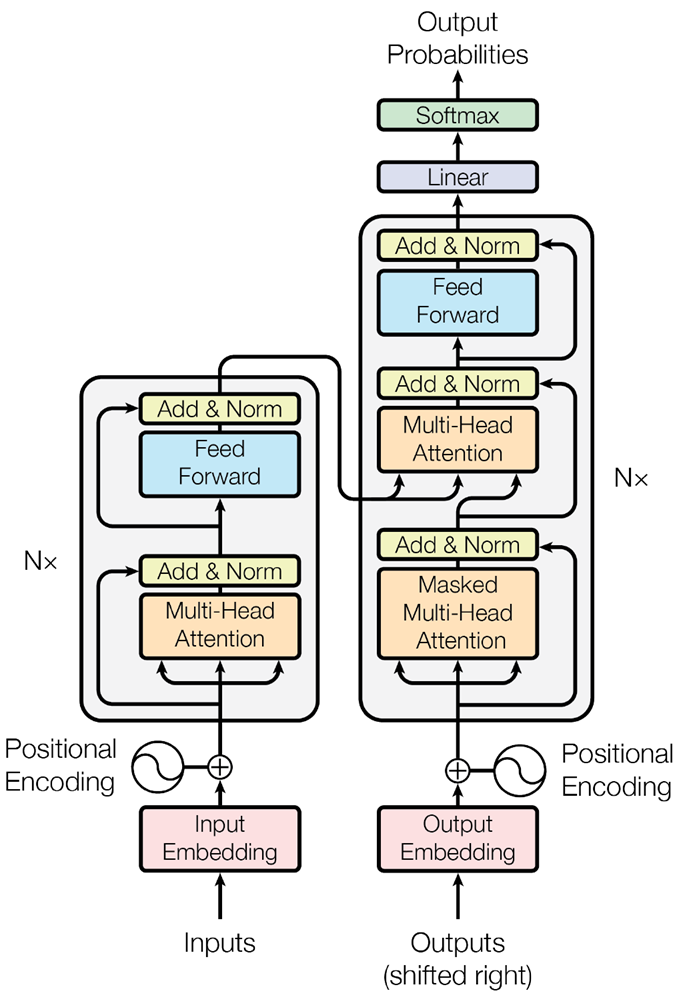

## Multi-Head Attention

Transformers are sequence-to-sequence networks, i.e., for an input sequence (e.g., a sentence in English), we get an output sequence (e.g., a sentence in Spanish).
The input sequence is first transformed into embeddings as like RNN,
and positional encodings are then added to these embeddings.
The position-aware embeddings are then transformed into three vectors, **query**, **key**, and **value** using learnable weights, and used to build the attention layers.
Finally, we use them to build Transformer encoder and decoder to get the final output sequence.
For this section, we will assume that we have the **query**, **key**, and the **value** vector and work on them.
Specifically, we will implement **multi-head attention**, which performs **scaled dot-product attention** over different query, key, and value triplets and merge them. 
There is also a variant called **masked attention**, but it is easy to implement it once we have implemented the basic multi-head attention.

The figure below highlights the multi-head attention layer inside the Transformer model:

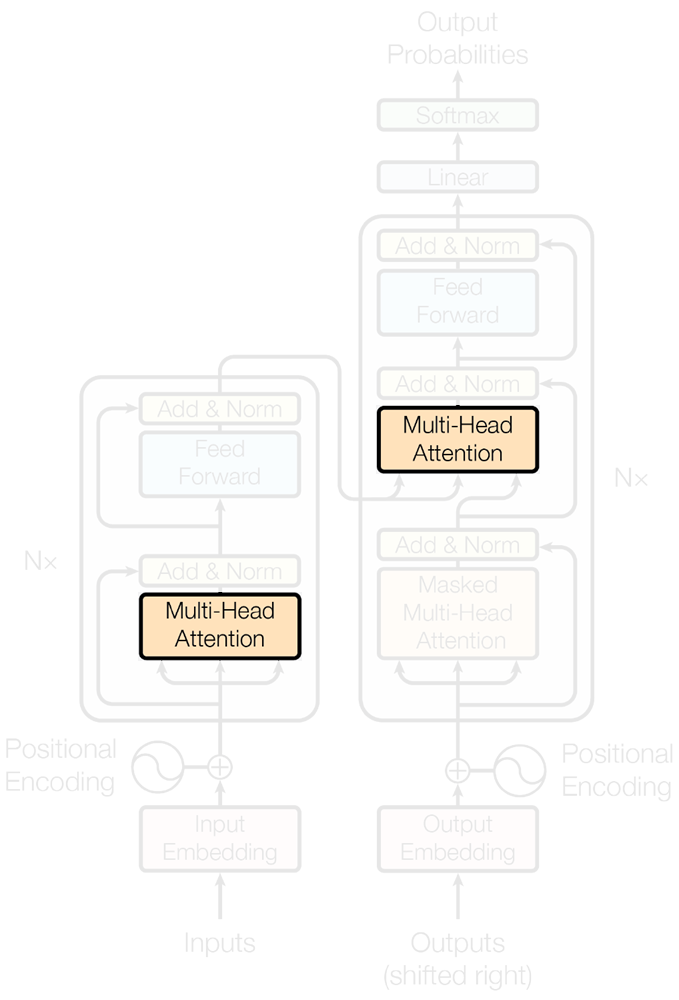

### Scaled Dot Product

Taking inspiration from information retreival paradigm, Transformers have the notion of **query**, **key**, and **value**;
given a **query**, we try extract information from **key**-**value** pairs.
Moving along those lines, we perform this mathematically by taking the weighted sum of **values** for each **query**, where the weight is computed by the dot product of **query** and **key**.
More precisely, for each query, we compute the dot product with all the keys, and then use the scalar output of those dot products as weights to compute the weighted sum of **values**.
Note that before finding the weighted sum, we also apply the softmax function to the weights vector.

The figure below illustrates the flow of the scaled dot product:

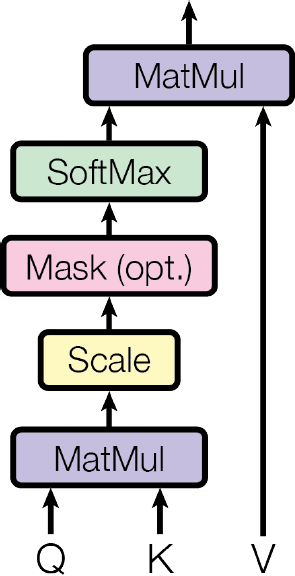

**Implement** the `scaled_dot_product_two_loop_single` function, which performs the scaled dot product with two loops for a single triplet of query, key, and value.
After implementing the scaled dot product, run the following to check your implementation.
You should see errors on the order of `1e-6` or less.

In [15]:
from transformers import scaled_dot_product_two_loop_single

K = 5  # number of words in a sentence
M = 4  # feature dimension of each word embedding

query = torch.linspace(-0.4, 0.6, steps=K*M).reshape(K, M)
key = torch.linspace(-0.8, 0.5, steps=K*M).reshape(K, M)
value = torch.linspace(-0.3, 0.8, steps=K*M).reshape(K, M)

y = scaled_dot_product_two_loop_single(query, key, value)
y_ans = torch.tensor([
    [0.082835, 0.140730, 0.198624, 0.256519],
    [0.135182, 0.193077, 0.250971, 0.308866],
    [0.188477, 0.246372, 0.304266, 0.362161],
    [0.240913, 0.298808, 0.356702, 0.414597],
    [0.290813, 0.348707, 0.406602, 0.464497],
]).to(torch.float32)
print('scaled_dot_product_two_loop_single error:', rel_error(y_ans, y))

scaled_dot_product_two_loop_single error: 5.453636009704136e-07


**Implement** `scaled_dot_product_two_loop_batch`, which performs the scaled dot product with two loops for a batch of triplets of query, key, and value.
After implementing the scaled dot product, run the following to check your implementation.
You should see errors on the order of `1e-6` or less.

In [16]:
from transformers import scaled_dot_product_two_loop_batch

N = 2  # number of sentences
K = 5  # number of words in a sentence
M = 4  # feature dimension of each word embedding

query = torch.linspace(-0.4, 0.6, steps=N*K*M).reshape(N, K, M)
key = torch.linspace(-0.8, 0.5, steps=N*K*M).reshape(N, K, M)
value = torch.linspace(-0.3, 0.8, steps=N*K*M).reshape(N, K, M)

y = scaled_dot_product_two_loop_batch(query, key, value)
y_ans = torch.tensor([
    [
        [-0.096026, -0.067821, -0.039616, -0.011411],
        [-0.089910, -0.061704, -0.033499, -0.005294],
        [-0.083763, -0.055558, -0.027353,  0.000852],
        [-0.077599, -0.049394, -0.021188,  0.007017],
        [-0.071428, -0.043223, -0.015018,  0.013188],
    ],
    [
        [ 0.498840,  0.527045,  0.555250,  0.583455],
        [ 0.504988,  0.533193,  0.561398,  0.589603],
        [ 0.511106,  0.539311,  0.567516,  0.595721],
        [ 0.517183,  0.545388,  0.573593,  0.601798],
        [ 0.523208,  0.551413,  0.579618,  0.607823],
    ]
]).to(torch.float32)
print('scaled_dot_product_two_loop_batch error:', rel_error(y_ans, y))

scaled_dot_product_two_loop_batch error: 3.953143785094111e-07


**Implement** `scaled_dot_product_no_loop_batch`, which is the fully vectorized version of your implementation above.
You can ignore the argument `mask` for now, which we will revisit later when implementing masked multi-head attention.
After implementing the scaled dot product, run the following to check your implementation.
You should see errors on the order of `1e-5` or less.

In [17]:
from transformers import scaled_dot_product_no_loop_batch

N = 2  # number of sentences
K = 5  # number of words in a sentence
M = 4  # feature dimension of each word embedding

query = torch.linspace(-0.4, 0.6, steps=N*K*M).reshape(N, K, M)
key = torch.linspace(-0.8, 0.5, steps=N*K*M).reshape(N, K, M)
value = torch.linspace(-0.3, 0.8, steps=N*K*M).reshape(N, K, M)

y, _ = scaled_dot_product_no_loop_batch(query, key, value)
y_ans = torch.tensor([
    [
        [-0.09603, -0.06782, -0.03962, -0.01141],
        [-0.08991, -0.06170, -0.03350, -0.00529],
        [-0.08376, -0.05556, -0.02735, 0.00085],
        [-0.07760, -0.04939, -0.02119, 0.00702],
        [-0.07143, -0.04322, -0.01502, 0.01319],
    ],
    [
        [0.49884, 0.52705, 0.55525, 0.58346],
        [0.50499, 0.53319, 0.56140, 0.58960],
        [0.51111, 0.53931, 0.56752, 0.59572],
        [0.51718, 0.54539, 0.57359, 0.60180],
        [0.52321, 0.55141, 0.57962, 0.60782],
    ],
]).to(torch.float32)
print('scaled_dot_product_no_loop_batch error: ', rel_error(y_ans, y))

scaled_dot_product_no_loop_batch error:  4.020571992067902e-06


#### Time Complexity

Transformers are infamous for their time complexity that depends on the size of the input sequence.
We can verify this now, as it comes from the scaled dot product we have implemented above.

First, run the cell below, which has a sequence length of 256.
The `%timeit` lines may take several seconds to run.

In [18]:
N = 64  # number of sentences
K = 256  # number of words in a sentence
M = 1024  # feature dimension of each word embedding

query = torch.linspace(-0.4, 0.6, steps=N*K*M).reshape(N, K, M)
key = torch.linspace(-0.8, 0.5, steps=N*K*M).reshape(N, K, M)
value = torch.linspace(-0.3, 0.8, steps=N*K*M).reshape(N, K, M)

%timeit -n 5 -r 2  y = scaled_dot_product_no_loop_batch(query, key, value)

387 ms ± 45.4 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


Next, run the cells below, which has a sequence length of 512, doubling the number from above.
You should see roughly 4 times slower with sequence length 512, hence showing that compleixity of the transformers increase *quadratically* with resprect to increase in the in sequence length.
The `%timeit` lines may take several seconds to run.

In [19]:
N = 64  # number of sentences
K = 512  # number of words in a sentence
M = 1024  # feature dimension of each word embedding

query = torch.linspace(-0.4, 0.6, steps=N*K*M).reshape(N, K, M)
key = torch.linspace(-0.8, 0.5, steps=N*K*M).reshape(N, K, M)
value = torch.linspace(-0.3, 0.8, steps=N*K*M).reshape(N, K, M)

%timeit -n 5 -r 2  y = scaled_dot_product_no_loop_batch(query, key, value)

1.29 s ± 161 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


### Attention Layer

Now that we have implemented the fully vectorized version of scaled dot product in `scaled_dot_product_no_loop_batch`, we will use it to implement the attention layer.

The figure below illustrates the flow of the attention layer, where `h` is the number of heads:

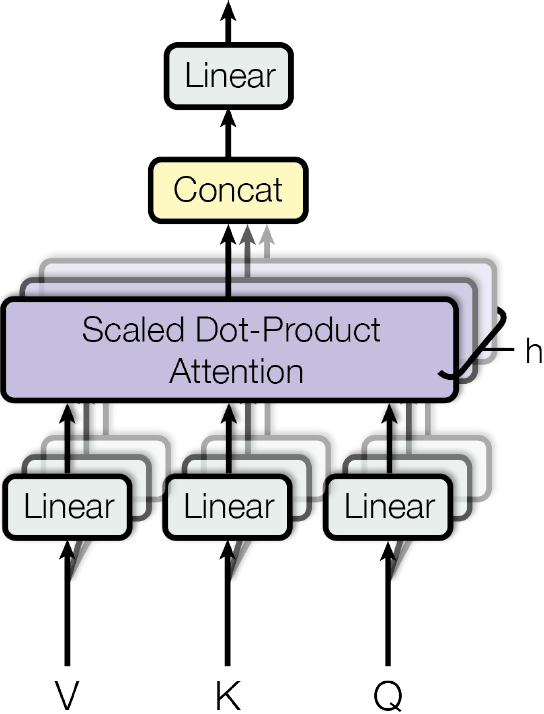

**Implement** the `SingleHeadAttention` module, which inherits from `nn.Module` and serves as a building block for the `MultiHeadAttention` layer.
After implementing the attention layer, run the following to check your implementation.
You should see errors on the order of `1e-6` or less.

In [20]:
from transformers import SingleHeadAttention

N = 2
K = 4
emb_dim = M = 4
dim_q = dim_k = 4

attn_single = SingleHeadAttention(emb_dim, dim_q, dim_k)

reset_seed(0)

for k, v in attn_single.named_parameters():
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

query = torch.linspace(-0.4, 0.6, steps=N*K*M).reshape(N, K, M)
key = torch.linspace(-0.8, 0.5, steps=N*K*M).reshape(N, K, M)
value = torch.linspace(-0.3, 0.8, steps=N*K*M).reshape(N, K, M)

query.requires_grad_().retain_grad()
key.requires_grad_().retain_grad()
value.requires_grad_().retain_grad()

y = attn_single(query, key, value)
dy = torch.randn(*y.shape)

y.backward(dy)
query_grad = query.grad

y_ans = torch.tensor([
    [
        [-1.103822, -0.372189,  0.359444,  1.091077],
        [-1.457916, -0.500666,  0.456585,  1.413835],
        [-1.743491, -0.604281,  0.534929,  1.674138],
        [-1.925843, -0.670444,  0.584954,  1.840353],
    ],
    [
        [-4.596705, -1.639518,  1.317669,  4.274856],
        [-4.655858, -1.660981,  1.333896,  4.328773],
        [-4.690051, -1.673387,  1.343277,  4.359941],
        [-4.710391, -1.680767,  1.348857,  4.378481],
    ],
])
query_grad_ans = torch.tensor([
    [
        [ 0.758951,  0.748664,  0.738377,  0.728090],
        [-2.053048, -2.025221, -1.997393, -1.969566],
        [ 0.235971,  0.232773,  0.229574,  0.226376],
        [-0.132641, -0.130843, -0.129045, -0.127248],
    ],
    [
        [ 0.436078,  0.430167,  0.424257,  0.418346],
        [ 0.136434,  0.134585,  0.132736,  0.130886],
        [-0.021468, -0.021177, -0.020886, -0.020595],
        [-0.076630, -0.075592, -0.074553, -0.073514],
    ],
])
print('SingleHeadAttention error:', rel_error(y_ans, y))
print('SingleHeadAttention error:', rel_error(query_grad_ans, query_grad))

SingleHeadAttention error: 1.012309070916907e-07
SingleHeadAttention error: 9.072583922998063e-07


Finally, using `SingleHeadAttention`, we will complete `MultiHeadAttention` by manipulating the shapes of input tensors based on number of heads in the multi-head attention layer.
Specifically, we design a network that uses multiple `SingleHeadAttention` layers on the same input to compute the output tensors, and concatenate them to generate a single output.
Note that this is not the implementation used in practice as it forces you to initialize multiple layers, but we use it here for simplicity.

**Implement** the `MultiHeadAttention` module, and run the following to check your implementation.
You should see errors on the order of `1e-6` or less.

In [21]:
from transformers import MultiHeadAttention

N = 2
K = 4
dim_in = M = 4
dim_out = 8
num_heads = 2
attn_multihead = MultiHeadAttention(num_heads, dim_in, dim_out)

reset_seed(0)

for k, v in attn_multihead.named_parameters():
    # print(k, v.shape) # uncomment this to see the weight shape
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

query = torch.linspace(-0.4, 0.6, steps=N*K*M).reshape(N, K, M)
key = torch.linspace(-0.8, 0.5, steps=N*K*M).reshape(N, K, M)
value = torch.linspace(-0.3, 0.8, steps=N*K*M).reshape(N, K, M)

query.requires_grad_().retain_grad()
key.requires_grad_().retain_grad()
value.requires_grad_().retain_grad()

y = attn_multihead(query, key, value)
dy = torch.randn(*y.shape)

y.backward(dy)
query_grad = query.grad

y_ans = torch.tensor([
    [
        [-0.706941,  0.157538,  1.022017,  1.886496],
        [-0.373165,  0.403979,  1.181122,  1.958265],
        [-0.103976,  0.602731,  1.309439,  2.016146],
        [ 0.067913,  0.729644,  1.391375,  2.053106],
    ],
    [
        [ 2.585523,  2.588497,  2.591471,  2.594446],
        [ 2.641281,  2.629665,  2.618050,  2.606435],
        [ 2.673511,  2.653463,  2.633414,  2.613365],
        [ 2.692686,  2.667619,  2.642554,  2.617488],
    ],
])
query_grad_ans = torch.tensor([
    [
        [-1.450655, -1.430992, -1.411330, -1.391667],
        [ 0.468629,  0.462277,  0.455925,  0.449573],
        [-0.163647, -0.161429, -0.159211, -0.156993],
        [ 0.387660,  0.382406,  0.377151,  0.371897],
    ],
    [
        [-0.312485, -0.308250, -0.304014, -0.299779],
        [-0.025843, -0.025492, -0.025142, -0.024792],
        [ 0.013296,  0.013116,  0.012935,  0.012755],
        [ 0.082625,  0.081505,  0.080385,  0.079265],
    ]
])
print('MultiHeadAttention error:', rel_error(y_ans, y))
print('MultiHeadAttention grad error:', rel_error(query_grad_ans, query_grad))

MultiHeadAttention error: 5.312580740159374e-07
MultiHeadAttention grad error: 1.2634590229217352e-06


## Layer Normalization

The figure below highlights the layer normalization part inside the Transformer model.
Note that the layer normalization we will implement corresponds to **Norm** in the **Add & Norm** block, and we will implement the **Add** part later in a different manner.

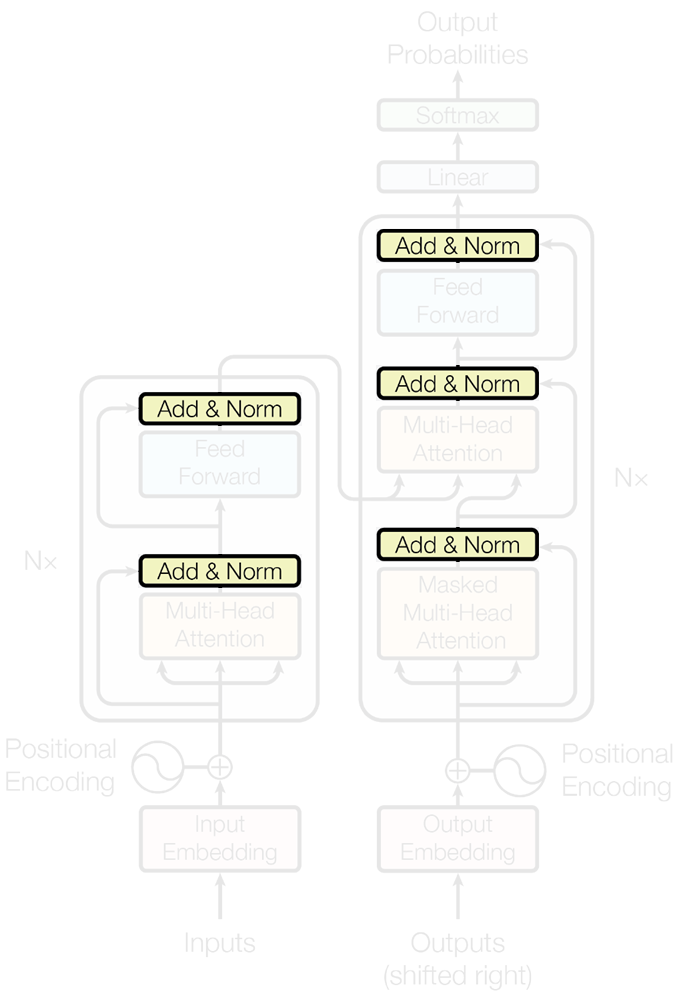

While BatchNorm has shown to be effective with CNNs, it brings some issues, e.g., it relies on the statistics along with the batch dimension, which might not give us good results when the batch size is small.
Ba et al. proposed LayerNorm that takes into account these problems and has become a standard in sequence-to-sequence tasks.
LayerNorm depends on individual time steps or each element of the sequence only, so it can be parallelized and its behavior at the test time is similar to the training time, making it easier to debug than BatchNorm in a complex neural network implementation.

**Implement** the `LayerNorm` module and run the following to check your implementation.
You should see errors on the order of `1e-6` or less.

[[Ba et al.] Layer Normalization. arXiv:1607.06450.](https://arxiv.org/abs/1607.06450)

In [22]:
from transformers import LayerNorm

reset_seed(0)

N = 2
K = 4
norm = LayerNorm(K)
x = torch.linspace(-0.4, 0.6, steps=N * K).reshape(N, K)
x.requires_grad_().retain_grad()

y = norm(x)
dy = torch.randn(*y.shape)

y.backward(dy)
x_grad = x.grad

y_ans = torch.tensor([
    [-1.341641, -0.447213,  0.447214,  1.341641],
    [-1.341641, -0.447214,  0.447214,  1.341641],
])
x_grad_ans = torch.tensor([
    [  5.705237,  -2.772891, -11.569927,   8.637581],
    [  2.262421,  -4.443298,   2.099332,   0.081545],
])
print('LayerNorm error:', rel_error(y_ans, y))
print('LayerNorm grad error:', rel_error(x_grad_ans, x_grad))

LayerNorm error: 1.777066950997379e-07
LayerNorm grad error: 8.242699358750961e-08


## Feed-Forward Network

The figure below highlights the feed-forward network inside the Transformer model.

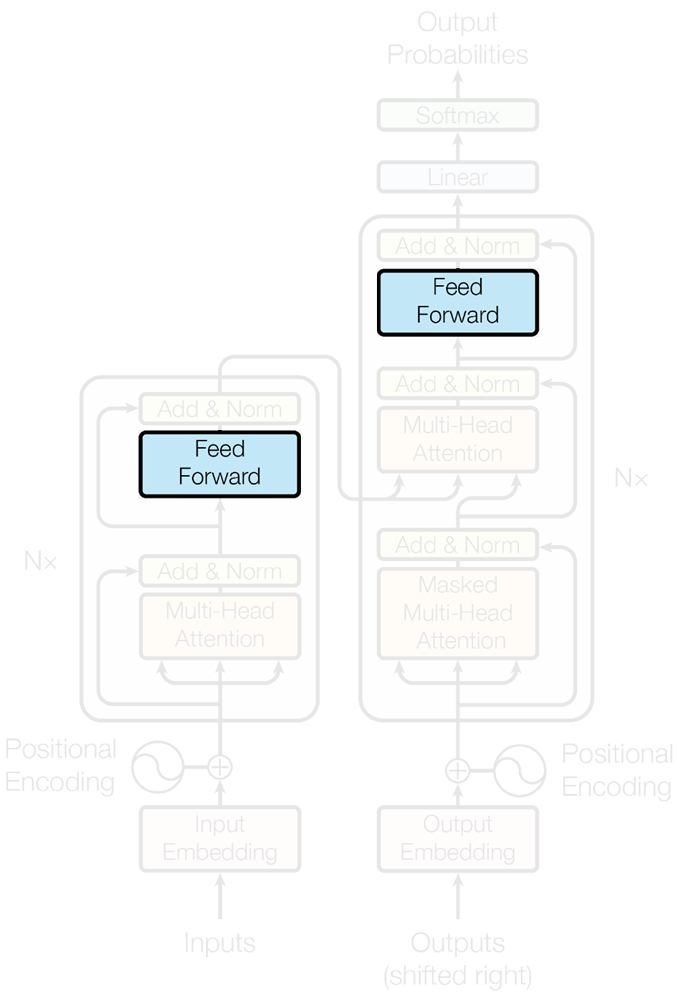

The feed-forward network proposed in the original Transformer paper is the 2-layer MLP with ReLU activation in the middle, i.e., it has the following architecture in PyTorch:

`Linear - ReLU - Linear`

**Implement** the `FFN` module and run the following to check your implementation.
You should see errors on the order of `1e-6` or less.

In [23]:
from transformers import FFN

N = 2
K = 4
emb_dim = M = 4

ffn = FFN(emb_dim, 2 * emb_dim)

reset_seed(0)

for k, v in ffn.named_parameters():
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

x = torch.linspace(-0.4, 0.6, steps=N * K).reshape(N, K) 
x.requires_grad_().retain_grad()

y = ffn(x)
dy = torch.randn(*y.shape)

y.backward(dy)
x_grad = x.grad

y_ans = torch.tensor([
    [-2.461607, -0.716616,  1.028376,  2.773367],
    [-7.560843, -1.695573,  4.169699, 10.034969],
])
x_grad_ans = torch.tensor([
    [-3.602662, -4.201323, -4.799984, -5.398645],
    [ 4.937656,  5.802677,  6.667698,  7.532719],
])
print('FFN error:', rel_error(y_ans, y))
print('FFN grad error:', rel_error(x_grad_ans, x_grad))

FFN error: 4.751755013196574e-08
FFN grad error: 3.1651066489015564e-08


## Transformer Encoder

The figure below highlights the encoder part inside the Transformer model:

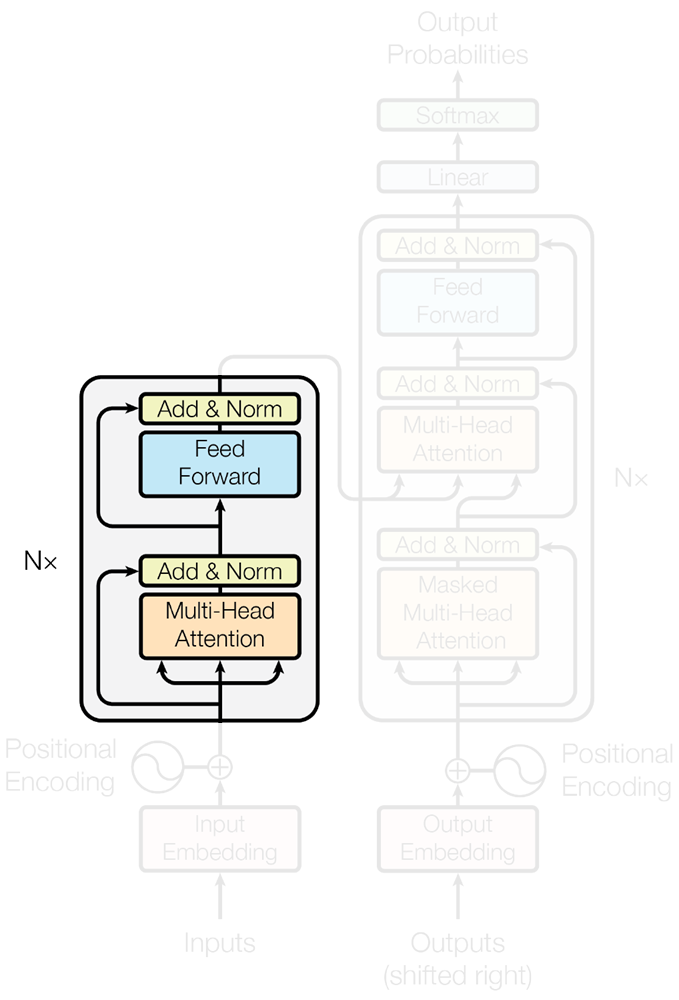

Each Transformer encoder block first passes the input to the multi-head self-attention, i.e., query, key, and value are from the same input.
A residual connection is employed around the multi-head attention, followed by layer normalization.
Then, the output is passed to a feed-forward network with a residual connection followed by layer normalization.
The final Transformer encoder network is the stack of multiple encoder blocks.

**Implement** the `EncoderBlock` module and run the following to check your implementation.
You should see errors on the order of `1e-6` or less.

In [24]:
from transformers import EncoderBlock

N = 2
K = 4
emb_dim = M = 4
num_heads = 2
ffn_dim = 8
dropout = 0.2

x1 = torch.linspace(-0.4, 0.6, steps=N*K*M).reshape(N, K, M)
x1.requires_grad_()

enc_block1 = EncoderBlock(num_heads, emb_dim, ffn_dim, dropout)

reset_seed(0)

for k, v in enc_block1.named_parameters():
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

y1_ans = torch.tensor([
    [
        [ 0.697812, -0.390105,  0.879358,  1.975782],
        [ 0.688346, -0.392530,  0.888954,  1.929500],
        [-0.769800, -0.090084,  0.223290,  3.525273],
        [ 0.406092, -0.251720,  0.558701,  3.106834],
    ],
    [
        [-1.175766,  0.269606,  0.853447,  2.035491],
        [-0.456219,  0.027211,  0.471513,  3.314699],
        [ 0.889649, -0.520399,  0.654364,  2.546383],
        [ 0.395786, -0.255856,  0.544811,  3.131654],
    ]
])
y1 = enc_block1(x1)
print('EncoderBlock error 1:', rel_error(y1_ans, y1))

N = 2
K = 4
emb_dim = M = 4
num_heads = 1
ffn_dim = 8
dropout = 0.2

x2 = torch.linspace(-0.4, 0.6, steps=N*K*M).reshape(N, K, M)
x2.requires_grad_()

enc_block2 = EncoderBlock(num_heads, emb_dim, ffn_dim, dropout)

reset_seed(1)

for k, v in enc_block2.named_parameters():
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

y2 = enc_block2(x2)
y2_ans = torch.tensor([
    [
        [-0.302138,  0.016558,  0.532563,  3.231666],
        [ 0.846841, -0.527825,  0.842866,  1.874692],
        [ 0.545233, -0.342867,  0.536914,  3.069863],
        [ 0.606795, -0.372063,  0.928218,  1.779381],
    ],
    [
        [-0.321269, -0.009486,  0.480509,  3.315364],
        [-0.502755,  0.043165,  0.474519,  3.303199],
        [ 0.587460, -0.364354,  0.541913,  3.036960],
        [ 0.266119, -0.333787,  0.380259,  3.343422],
    ]
])
print('EncoderBlock error 2:', rel_error(y2_ans, y2))

EncoderBlock error 1: 3.0434056602070045e-07
EncoderBlock error 2: 9.805089790020615e-08


## Transformer Decoder

The figure below highlights the decoder part inside the Transformer model:

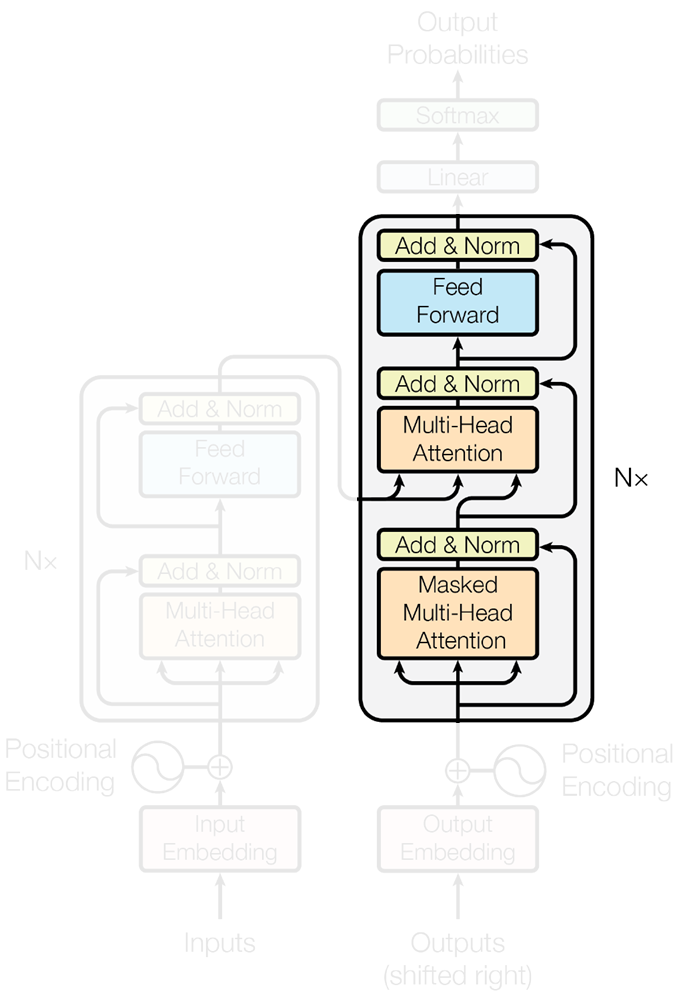

Now, we will look at the Transformer decoder part.
We learned the encoder-only Transformer that can be used for tasks like sequence classification.
However, for more complicated tasks like sequence to sequence, we need a decoder network that can transform the output of the encoder to a target sequence.
This kind of architecture is important in tasks like language translation, where we have a sequence as input and a sequence as output.
The Transformer decoder takes the output from the encoder as well as the previous output as inputs to generate the next output.

During training, we use a mask on the input so that the decoder network cannot look ahead in the future and we sequentially process the data during inference, described as **masked multi-head attention** in the diagram.
Hence, before implementing the decoder, we first need to modify the `MultiHeadAttention` to get the mask.

To understand the reason why we need masking for the decoder part, let's consider an example:
suppose we have an input `BOS POSITIVE 01 add POSITIVE 00 EOS`, or `1+0` in math.
The corresponding output is `BOS POSITIVE 01 EOS`, or `+1` in math.
Let's focus on the output sequence here.
After pre-processing, the output sequence is of length 5 (`BOS`, `POSITIVE`, `0`, `1`, `EOS`), and it is transformed into **key**, **query**, and **value** matrix of dimension $5 \times M$, where $M$ is the embedding dimension of the Transformer.

Now, suppose we input these vectors to the `scaled_dot_product_no_loop_batch` *without* masking.
It will compute the scaled dot product between **query** and **key** to generate a $5 \times 5$ matrix, where the first row (of shape $1 \times 5$) tells us how much the word `EOS` is related with `BOS`, `POSITIVE`, `0`, `1`, and `EOS`.
This means that it will use the weights of all these tokens to learn the final sequence that is to be predicted.
This is okay when we are training the model, but what happens when we perform inference?
At inference time, we start with a brand new expression as an input to the encoder, but the decoder only gets the starting token `EOS` as an input, and we don't know about the rest of the tokens in the sequence.
Hence, a solution to this problem is to mask the weights inside the function `scaled_dot_product_no_loop_batch` for the decoder part.
This masking should prevent the decoder from accessing the future or next elements.

Now that we understand why masking is necessary, we will generate a mask for our purpose, and then update the `scaled_dot_product_no_loop_batch` to take account of the mask if given.

**Implement** the `get_subsequent_mask` function to generate an appropriate mask to prevent the decoder from accessing the future input values.

After implementing the function, run the following to check your implementation.
The errors should be all zero.

In [25]:
from transformers import get_subsequent_mask

N = 4
K = 3

seq = torch.linspace(-0.4, 0.6, steps=N*K).reshape(N, K)
seq.requires_grad_()

mask = get_subsequent_mask(seq)

mask_ans = torch.tensor([
    [[False, True, True], [False, False, True], [False, False, False]],
    [[False, True, True], [False, False, True], [False, False, False]],
    [[False, True, True], [False, False, True], [False, False, False]],
    [[False, True, True], [False, False, True], [False, False, False]],
])
print('mask error:', rel_error(mask.float(), mask_ans.float()))

mask error: 0.0


**Update** `scaled_dot_product_no_loop_batch` to handle a mask if given and run the following to check your implementation.
You should see errors on the order of `1e-6` or less.

In [26]:
from transformers import scaled_dot_product_no_loop_batch

N = 4
K = 3
M = 3

query = torch.linspace(-0.4, 0.6, steps=N*K*M).reshape(N, K, M)
key = torch.linspace(-0.1, 0.2, steps=N*K*M).reshape(N, K, M)
value = torch.linspace(0.4, 0.8, steps=N*K*M).reshape(N, K, M)

mask = get_subsequent_mask(key[:,:,0])
y, _ = scaled_dot_product_no_loop_batch(query, key, value, mask)

y_ans = torch.tensor([
    [
        [0.400000, 0.411429, 0.422857],
        [0.417034, 0.428462, 0.439891],
        [0.434082, 0.445511, 0.456939],
    ],
    [
        [0.502857, 0.514286, 0.525714],
        [0.519989, 0.531418, 0.542846],
        [0.537201, 0.548630, 0.560058],
    ],
    [
        [0.605714, 0.617143, 0.628571],
        [0.622944, 0.634373, 0.645802],
        [0.640320, 0.651749, 0.663177],
    ],
    [
        [0.708571, 0.720000, 0.731429],
        [0.725900, 0.737328, 0.748757],
        [0.743439, 0.754867, 0.766296],
    ],
])
print('scaled_dot_product_no_loop_batch error 2:', rel_error(y_ans, y))

scaled_dot_product_no_loop_batch error 2: 3.1113119290110625e-07


Now, we are ready to implement the decoder part.

**Implement** the `DecoderBlock` module and run the following to check your implementation.
You should see errors on the order of `1e-6` or less.

In [27]:
from transformers import DecoderBlock

N = 2
K1 = 4
K2 = 2
emb_dim = M = 4
num_heads = 2
ffn_dim = 8
dropout = 0.2

x1 = torch.linspace(-0.4, 0.6, steps=N*K1*M).reshape(N, K1, M)
enc_out1 = torch.linspace(-0.4, 0.6, steps=N*K2*M).reshape(N, K2, M)
dec_block1 = DecoderBlock(num_heads, emb_dim, ffn_dim, dropout)

reset_seed(0)

for k, v in dec_block1.named_parameters():
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

y1 = dec_block1(x1, enc_out1)

y1_ans = torch.tensor([
    [
        [ 0.417588, -0.257970,  0.558115,  3.103165],
        [ 0.250399, -0.329510,  0.376666,  3.351623],
        [-0.367072, -0.007003,  0.462240,  3.338659],
        [ 0.853667, -0.539694,  0.842116,  1.852610],
    ],
    [
        [ 0.313035, -0.337866,  0.399770,  3.312970],
        [ 0.424316, -0.264858,  0.553001,  3.108122],
        [ 0.413969, -0.262506,  0.548628,  3.118841],
        [ 0.415462, -0.260602,  0.552552,  3.112427],
    ]
])
print('DecoderBlock error 1:', rel_error(y1, y1_ans))

N = 2
K1 = 4
K2 = 4
emb_dim = M = 4
num_heads = 2
ffn_dim = 4
dropout = 0.2

x2 = torch.linspace(-0.4, 0.6, steps=N*K1*M).reshape(N, K1, M)  
enc_out2 = torch.linspace(-0.4, 0.6, steps=N*K2*M).reshape(N, K2, M)  
dec_block2 = DecoderBlock(num_heads, emb_dim, ffn_dim, dropout)

reset_seed(1)

for k, v in dec_block2.named_parameters():
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

y2 = dec_block2(x2, enc_out2)

y2_ans = torch.tensor([
    [
        [ 0.389099, -0.248226,  0.551061,  3.124969],
        [-0.248371, -0.074003,  0.425682,  3.393496],
        [-0.753520, -0.088140,  0.229827,  3.524201],
        [ 0.558901, -0.344364,  0.545643,  3.050291],
    ],
    [
        [ 0.513093, -0.337067,  0.520397,  3.108779],
        [ 0.394981, -0.258107,  0.540981,  3.137500],
        [ 0.725584, -0.383321,  0.842535,  2.138883],
        [ 0.379279, -0.255218,  0.533837,  3.153653],
    ]
])
print('DecoderBlock error 2:', rel_error(y2, y2_ans))

DecoderBlock error 1: 7.558121420206939e-08
DecoderBlock error 2: 6.765181235822717e-08


## Transformer

Based on the implementation of `EncoderBlock` and `DecoderBlock`, we have implemented the `Encoder` and `Decoder` networks for you.
You should be able to understand the inputs and outputs of them.
Specifically, the `Decoder` module includes the last fully-connected layer that maps the feature dimension to the vocabulary length.

We will now add all pieces together to implement the complete Transformer model.
We have implemented the positional encoding, encoder, and decoder, so we have left the input and output embedding layers.
For input and output embedding layers, we will simply take `nn.Embedding`.

**Implement** the `Transformer` module using all components we have implemented. You should pass all assertions in the **Data Loader** section. 

# Part 3: Addition and Subtraction with Transformer

In this part, we will train and evaluate a Transformer model on the toy dataset for simple arithmatic operations.
The overall tasks are divided into three parts:

- Overfitting small data
- Training Transformer on the complete dataset
- Qualitative analysis: inference and visualizing the attention

Before going further, make sure you ran the script around the **Load the Toy Dataset** section to load and split the toy dataset and the **Data Pre-processing** section to create the vocabulary and token dictionary.

## Data Loader

Now, we will construct data loaders with positional encodings.
The function of data loaders is to return a batch for training/validation data.
We first define a dataset class inherited from `torch.utils.data.Dataset` that gives us a single element in the batch and then use a `DataLoader` class to wrap the dataset.
The dataset class consists of two functions that you might need to change for your purpose.
The first function is `__init__`, which consists of the components that are *static*, in other words, these are the variables that won't change when we want the next element from the complete data.
The second function is `__getitem__`, which usually returns a data, its label, and other information if necessary, e.g., positional encodings in our case.

To get the final data loader, we wrap the `Dataset` instances with the `torch.utils.data.DataLoader` class.

You don't have to implement anything here, but run the following script.

In [28]:
from transformers import pos_enc_simple, AddSubDataset
from torch.utils.data import DataLoader

batch_size = 4
emb_dim = 32
pos_enc = pos_enc_simple

train_dataset = AddSubDataset(
    x_train, y_train, token_dict, SPECIAL_TOKENS, emb_dim, pos_enc
)
val_dataset = AddSubDataset(
    x_val, y_val, token_dict, SPECIAL_TOKENS, emb_dim, pos_enc
)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, drop_last=False
)

Run the following script to check your implementation of the `Transformer` module.
You should pass all assertions.

In [29]:
from transformers import Transformer

num_heads = 4
# emb_dim = 32  # should be consistent with the one in the dataset
ffn_dim = 64
num_enc_layers = 4
num_dec_layers = 4
vocab_len = len(vocab)
dropout = 0.2

model = Transformer(
    num_heads,
    emb_dim,
    ffn_dim,
    num_enc_layers,
    num_dec_layers,
    vocab_len,
    dropout,
)

reset_seed(0)

for k, v in model.named_parameters():
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

for it in train_loader:
    inp, inp_pos, tgt, tgt_pos = it
    break

model = model.to(device)
inp = inp.to(device)
inp_pos = inp_pos.to(device)
tgt = tgt.to(device)
tgt_pos = tgt_pos.to(device)

out = model(inp, inp_pos, tgt, tgt_pos)
assert out.shape[0] == batch_size * (tgt.shape[1] - 1)
assert out.shape[1] == vocab_len
print('All assertions passed.')

RuntimeError: ignored

## Overfitting to Small Dataset

Now that we have implemented the Transformer model, let's overfit on a small subset of the training dataset.
This will ensure that the implementation is correct and working for the task.
Before doing that, a couple of things to keep in mind:

- We have implemented two versions of positional encodings: simple and sinusoid.
For overfitting, we will use the simple positional encoding, but feel free to experiment with both when training on the complete dataset.
- Two loss functions are provided for you in `transformers.py`. One is the cross-entropy loss and the other is the `LabelSmoothingLoss`.
For overfitting, we will use the cross-entropy loss, but feel free to experiment with both when training on the complete dataset.
- We ususally take the idea of **learning rate warmup** when training Transformers, i.e., for the first few number of iterations or epochs, we first train the model with a lower learning rate and later (gradually) increase the learning rate to make the network learn faster.
Intuitively, warmup helps to attain a stable manifold in the loss function, and then we increase the learning rate to learn faster in this stable manifold.
For overfitting, we do NOT apply learning rate warmup as it is not necessary for such small data, but you should keep this in mind when training on the complete dataset.

We provide training and validation code in `common/helpers.py`, `train` and `val`.
Here, `train` has three parameters that you should pay attention to:
- `warmup_interval` specifies the number of iterations that the network should train with a low learning rate.
In other words, its the number of iterations after which the network will have the higher learning rate.
- `warmup_lr` is the learning rate that will be used during warmup.
- `lr` is the learning rate that will get used after the warmup. If `warmup_interval` is `None`, we do not apply learning rate warmup and simply start training with this learning rate.

Here, we overfit the model with 150 epochs, i.e., we visit all data 150 times in total in random order.

In [30]:
from common.helpers import train as train_transformer
from transformers import Transformer, CrossEntropyLoss

num_heads = 4
# emb_dim = 32  # should be consistent with the one in the dataset
ffn_dim = 32
num_enc_layers = 1
num_dec_layers = 1
vocab_len = len(vocab)
dropout = 0.2

loss_func = CrossEntropyLoss

num_epochs = 150  # number of epochs
warmup_interval = None  # number of iterations for warmup
warmup_lr = 6e-6  # learning rate for warmup
lr = 1e-3  # learning rate after warmup

overfit_model = Transformer(
    num_heads,
    emb_dim,
    ffn_dim,
    num_enc_layers,
    num_dec_layers,
    vocab_len,
    dropout,
)

small_dataset = torch.utils.data.Subset(
    train_dataset, torch.linspace(0, len(train_dataset)-1, steps=4).long()
)
small_train_loader = torch.utils.data.DataLoader(
    small_dataset, batch_size=4, pin_memory=True, num_workers=1, shuffle=False
)

# Overfitting the model
train_transformer(
    overfit_model,
    small_train_loader,
    small_train_loader,
    loss_func,
    num_epochs=num_epochs,
    batch_size=batch_size,
    warmup_interval=warmup_interval,
    warmup_lr=warmup_lr,
    lr=lr,
    device=device,
)

Training started...


RuntimeError: ignored

Now, run the following script to check the training accuracy.
The training set accuracy should be close to 100% after 150 epochs.
It should take about a minute to run training.

In [31]:
from common.helpers import val as val_transformer

_, overfit_acc = val_transformer(model, small_train_loader, loss_func,
                                 batch_size=batch_size, device=device)
print('Overfitting accuracy: {:5.2f}'.format(overfit_acc*100.))

RuntimeError: ignored

## Training Transformer

Now that we have confirmed that the Transformer model can overfit to a small subset, let's train the model on the entire training dataset.

Run the below cells to fit the model using the complete data. Keep in mind the various things you could experiment with here, losses, positional encodings, warm up routines and learning rates. You could also play with the size of the model but that will require more time to train on Colab.

You should achieve at least **80% accuracy** on the validation set.

In [32]:
from common.helpers import train as train_transformer
from transformers import Transformer, find_transformer_parameters

batch_size = 256
vocab_len = len(vocab)

num_heads, emb_dim, ffn_dim, num_enc_layers, num_dec_layers, dropout, \
    loss_func, pos_enc, num_epochs, warmup_interval, warmup_lr, lr = \
    find_transformer_parameters()

train_dataset = AddSubDataset(
    x_train, y_train, token_dict, SPECIAL_TOKENS, emb_dim, pos_enc
)
val_dataset = AddSubDataset(
    x_val, y_val, token_dict, SPECIAL_TOKENS, emb_dim, pos_enc
)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, drop_last=False
)

model = Transformer(
    num_heads,
    emb_dim,
    ffn_dim,
    num_enc_layers,
    num_dec_layers,
    vocab_len,
    dropout,
)

# Training the model on the entire dataset
train_transformer(
    model,
    train_loader,
    val_loader,
    loss_func,
    num_epochs,
    lr = lr,
    batch_size=batch_size,
    warmup_interval=warmup_interval,
    device=device
)

Training started...


RuntimeError: ignored

Once training is done, run the cell below to get the validation accuracy.

In [33]:
from common.helpers import val as val_transformer

_, val_acc = val_transformer(model, val_loader, loss_func,
                             batch_size=batch_size, device=device)
print('Validation accuracy: {:5.2f}'.format(val_acc*100.))

RuntimeError: ignored

If you are satisfied with the validation accuracy, save the model by running the script below.
There is no hard constraint, but we expect your model size is less than 4MB.

In [ ]:
weights_path = os.path.join(GOOGLE_DRIVE_PATH, 'transformers.pt')
torch.save(model.state_dict(), weights_path)

## Qualitative Analysis

Now that we have trained a model, let's look at the final results.
We will first look at the results from the validation data and visualize the attention weights (recall `self.weights_softmax`).
These attention weights should give you some intuition about what the network learns.
We have implemented everything for you here and the intention is to help you probe the model and understand about what does the network learn.

### Qualitative Result from the Validation Data

In the below cell, we pick the very first data point in the validation data and find the result on it.
The output does not have to be correct, but it is likely to be correct if your model is trained well.

In [ ]:
from common.helpers import inference

for it in val_loader:
    break
inp, inp_pos, tgt, tgt_pos = it
opposite_tokens_to_str = {v: k for k, v in token_dict.items()}

model = model.to(device)
inp = inp.to(device)
inp_pos = inp_pos.to(device)
tgt = tgt.to(device)
tgt_pos = tgt_pos.to(device)

b = 0

inp_exp = inp[b:b+1, :]
inp_exp_pos = inp_pos[b:b+1]
tgt_pos_exp = tgt_pos[b:b+1, :]

inp_seq = [opposite_tokens_to_str[w.item()] for w in inp_exp[0]]
print('Input  sequence:', ' '.join(inp_seq))

model.eval()
out_exp, _ = inference(model, inp_exp, inp_exp_pos, tgt_pos_exp,
                       tgt.shape[1], device=device)

out_seq = ['BOS']
for i in range(1, out_exp.shape[1]):
    sym = opposite_tokens_to_str[out_exp[0, i].item()]
    out_seq.append(sym)
    if sym == 'EOS':
        break
print('Output sequence:', ' '.join(out_seq))

### Test Your Own Example

In the cell below, you can try any example in the input style, changing the variable `custom_seq`.
We have filled a placeholder expression for you, but feel free to change it.

In [ ]:
from transformers import str2token

# TODO: You can play with custom_seq
custom_seq = 'BOS NEGATIVE 22 add POSITIVE 07 EOS'

print('Input  sequence:', custom_seq)
custom_exp = str2token(custom_seq, token_dict, SPECIAL_TOKENS)
inp_exp = torch.tensor(custom_exp).to(device)

tgt_seq_len = 5
tgt_pos_exp = pos_enc(tgt_seq_len, emb_dim).to(device)

model.eval()
custom_out_exp, _ = inference(model, inp_exp, inp_exp_pos, tgt_pos_exp,
                              tgt_seq_len, device=device)

custom_out_seq = ['BOS']
for i in range(1, custom_out_exp.shape[1]):
    sym = opposite_tokens_to_str[custom_out_exp[0, i].item()]
    custom_out_seq.append(sym)
    if sym == 'EOS':
        break
print('Output sequence:', ' '.join(custom_out_seq))

### Visualizing the Attention Weights

In this part, we will visualize the attention weights for the first validation data.
There are seperate heatmaps for encoder and the decoder.
The ligher value in color shows higher associated between the token present in that row and column, and darker color shows a weak relation between them.

In [ ]:
from common.helpers import draw

for layer in range(num_enc_layers):
    fig, axs = plt.subplots(1, num_heads, figsize=(20, 10))
    print('Encoder Block Number', layer+1)
    for h in range(num_heads):
        draw(
            model.encoder.layers[layer]
            .attn.heads[h]
            .affinity_mat.data.cpu()
            .numpy()[0],
            inp_seq,
            inp_seq if h == 0 else [],
            ax=axs[h],
        )
    plt.show()
plt.close()

In [ ]:
from common.helpers import draw

for layer in range(num_dec_layers):
    fig, axs = plt.subplots(1, num_heads, figsize=(20, 10))

    print('Decoder block number:', layer+1)
    print()

    print('Decoder masked self-attention', layer+1)
    for h in range(num_heads):
        draw(
            model.decoder.layers[layer]
            .attn_mask.heads[h]
            .affinity_mat.data.cpu()
            .numpy()[0],
            out_seq,
            out_seq if h == 0 else [],
            ax=axs[h],
        )
    plt.show()
    print('Decoder cross-attention', layer+1)

    fig, axs = plt.subplots(1, num_heads, figsize=(20, 10))
    for h in range(num_heads):
        draw(
            model.decoder.layers[layer]
            .attn_cross.heads[h]
            .affinity_mat.data.cpu()
            .numpy()[0],
            inp_seq,
            out_seq if h == 0 else [],
            ax=axs[h],
        )
    plt.show()
    print()

# Submit Your Work
After completing the assignment, please check if all outputs are displayed properly and the outputs are same as what you expected.
Also, please check if you generated any additional cells and/or modified existing cells; you should not change them unless otherwise instructed with `TODO`.

Run the following cell to create a `.zip` file for you to download and turn in. Your change may not always be automatically saved, so **please MANUALLY SAVE every `*.ipynb` and `*.py` files before executing the following cell.**

In particular, if you come here by *Run all* command, **please MANUALLY SAVE this notebook and execute the following cell again;** otherwise, the ipynb file in the zip might not contain the last few execution results.

In [ ]:
from common.submit import make_submission

make_submission(GOOGLE_DRIVE_PATH, 5, option, name, idnum, group)